In [1]:
# import time libraries
import time
from datetime import datetime
from time import gmtime, strftime

# Set Begin Time to Measure Time to Run of Whole Notebook
begin_time = time.time()

In [2]:
## Pull Relavent Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import os
import math
import requests
from io import StringIO
#from StringIO import StringIO
import sys
import os.path
from IPython.display import display, HTML

# For Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Other
import scipy
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from datetime import timedelta

# For Confusion Matrix
from sklearn.metrics import confusion_matrix
import itertools

# Import Functions Built
from Functions import countplotshorizontal, null_values, histogram, stacked_bar, anova, spearman_df, spearman_chart, encode, QQ, plot_confusion_matrix

# Set Notebook Options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
bold = "\033[1m"
reset = "\033[0;0m"

## Modeling Libraries
## Create _csv.reader object
import csv
%pylab inline

from itertools import combinations
from numpy import array,array_equal

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import xgboost as feature_names

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\Armand\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'norm', 'histogram']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Some Links
#### https://www.kaggle.com/srodriguex/model-and-feature-selection-with-python/notebook
#### https://stackoverflow.com/questions/40257492/gridsearchcv-typeerror-stratifiedkfold-object-is-not-iterable

In [3]:
# Read Back in the DataFrame
os.chdir(sys.path[0] + '\\Data')
# os.chdir('C:\\Users\\apost\\Desktop\\Python\\CL\\LendingClub\\Data')

df = pd.read_pickle('df3.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429387 entries, 0 to 429386
Columns: 104 entries, id to initial_list_status_w
dtypes: datetime64[ns](1), float64(20), int32(20), int64(3), uint8(60)
memory usage: 139.2+ MB


In [4]:
display(HTML(df[0:5].to_html()))

,id,issue_d,OOT_Ind,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,roa,term__36_months,term__60_months,grade_A,grade_B,grade_C,grade_D,grade_E,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_Other,home_ownership_RENT,verification_status_Not_Verified,verification_status_Source_Verified,verification_status_Verified,purpose_Other,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_Other,addr_state_TX,initial_list_status_f,initial_list_status_w
0,10149566,2013-12-01,0,8000.000,10.990,2,10.404,15.750,0,1,2.750,1,18.600,34.600,16,5.595,0,21.799,22.956,2,2255,129,269,3.341,3.341,0,18,6,0,3,5,7,2,14,0.000,0,100.000,75.000,1,21.799,19.096,20.753,687.000,-17.385,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,10148122,2013-12-01,0,12000.000,7.620,3,11.477,12.610,0,0,3.618,0,21.018,55.700,30,4.812,0,34.940,23.561,4,2441,123,118,2.886,2.750,1,10,10,0,4,5,10,15,14,0.000,3,100.000,100.000,0,26.781,21.482,27.456,707.000,4.212,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
2,10129506,2013-12-01,0,20800.000,13.530,10,11.308,16.730,0,2,4.437,0,23.498,54.500,41,5.226,0,23.498,26.377,9,6811,115,186,0.000,0.000,0,0,0,1,8,16,17,1,40,0.000,3,90.200,50.000,0,23.498,21.538,0.000,687.000,9.826,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,10159611,2013-12-01,0,10000.000,9.670,7,11.533,15.550,2,0,2.750,0,19.839,44.400,22,5.670,0,25.903,23.267,3,973,243,290,4.072,2.603,0,25,8,1,3,4,6,9,13,0.000,1,77.300,66.700,0,25.903,19.544,25.521,672.000,4.683,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,10127816,2013-12-01,0,24000.000,13.530,10,11.513,22.180,0,0,3.341,0,23.127,76.700,39,5.700,539,34.925,24.340,7,4822,179,299,3.702,2.440,3,18,7,0,3,5,10,17,19,0.000,2,100.000,75.000,0,28.178,23.103,27.957,662.000,9.101,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1


In [5]:
ScaleList10x = ['annual_inc','dti','open_acc','revol_bal','revol_util','time_in_file','total_rev_hi_lim','avg_cur_bal','mo_sin_rcnt_rev_tl_op',
                'mo_sin_rcnt_tl','num_rev_tl_bal_gt_0','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit','fico_avg']

for i in range(0, len(ScaleList10x)):
    try:
        df[ScaleList10x[i]] = df[ScaleList10x[i]] * 10
    except:
        print('Variable ' + ScaleList10x[i] + ' Not in List')
    
df['roa'].quantile([.1, .2, .4, .5, .6, .8, .9])

Variable avg_cur_bal Not in List
Variable num_rev_tl_bal_gt_0 Not in List
Variable tot_hi_cred_lim Not in List


0.100   -20.529
0.200     2.800
0.400     5.533
0.500     6.575
0.600     7.602
0.800    10.255
0.900    12.540
Name: roa, dtype: float64

In [6]:
df['target'] = np.where(df['roa'] >= 10, 1, 0)
del df['issue_d']

ColumnList = df.columns.tolist()

In [7]:
for i in range(0,len(ColumnList)):
    if df[ColumnList[i]].dtype == 'object':
        df[ColumnList[i]] = df[ColumnList[i]]
    elif df[ColumnList[i]].dtype == 'float32':
        df[ColumnList[i]] = int(df[ColumnList[i]])
    elif df[ColumnList[i]].dtype == 'float64':
        df[ColumnList[i]] = df[ColumnList[i]].fillna(0).astype(np.int32)
    elif df[ColumnList[i]].dtype == 'int64':
        df[ColumnList[i]] = df[ColumnList[i]].fillna(0).astype(np.int32)
    elif df[ColumnList[i]].dtype == 'uint8':
        df[ColumnList[i]] = df[ColumnList[i]].fillna(0).astype(np.int32)
#     elif df[ColumnList[i]].dtype == 'category':
#         df[ColumnList[i]] = df[ColumnList[i]].fillna(0).astype(np.int32)
    else:
        df[ColumnList[i]] = df[ColumnList[i]]

In [8]:
df_OOT = df.loc[df['OOT_Ind'] == 1]
df_IT = df.loc[df['OOT_Ind'] == 0]

In [9]:
# Let's cutdown the dataset before beginning

df0 = df_IT.sample(frac = 0.25, replace = False, random_state = 42).copy(deep = True)
df0 = df_IT.reset_index()

print(len(df))
print(len(df0))

429387
353635


In [10]:
df_IT_IDs = df_IT[['target','id','roa','int_rate',
                   'grade_A','grade_B','grade_C','grade_D','grade_E']].copy(deep = True)

RemoveList = ['target','id','roa','int_rate',
              'grade_A','grade_B','grade_C','grade_D','grade_E']

# df_IT_IDs = df_IT[['target','id','roa','int_rate',
#                    'sub_grade_A1','sub_grade_A2','sub_grade_A3','sub_grade_A4','sub_grade_A5',
#                    'sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
#                    'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5',
#                    'sub_grade_D1','sub_grade_D2','sub_grade_D3','sub_grade_D4','sub_grade_D5',
#                    'sub_grade_E1','sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5',
#                    'sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4','sub_grade_F5',
#                    'sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5']].copy(deep = True)

# RemoveList = ['target','id','OOT_Ind','roa',
#               'sub_grade_A1','sub_grade_A2','sub_grade_A3','sub_grade_A4','sub_grade_A5',
#               'sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
#               'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5',
#               'sub_grade_D1','sub_grade_D2','sub_grade_D3','sub_grade_D4','sub_grade_D5',
#               'sub_grade_E1','sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5',
#               'sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4','sub_grade_F5',
#               'sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5']

for i in range(0, len(RemoveList)):
    try:
        ColumnList.remove(RemoveList[i])
    except:
        print('Variable ' + RemoveList[i] + ' Not in List')
                  
# ColumnList

In [11]:
TotalList = RemoveList + ColumnList

# Cutoff = len(['target','id','OOT_Ind','roa',
#               'sub_grade_A1','sub_grade_A2','sub_grade_A3','sub_grade_A4','sub_grade_A5',
#               'sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
#               'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5',
#               'sub_grade_D1','sub_grade_D2','sub_grade_D3','sub_grade_D4','sub_grade_D5',
#               'sub_grade_E1','sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5',
#               'sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4','sub_grade_F5',
#               'sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5'])

Cutoff = len(['target','id','OOT_Ind','roa',
              'grade_A','grade_B','grade_C','grade_D','grade_E'])

Cutoff

9

In [12]:
df_OOT = df_OOT[TotalList].copy(deep = True)
df0 = df0[TotalList].copy(deep = True)

df_OOT.sort_values(by = ['id'])

display(HTML(df0[0:5].to_html()))
# display(HTML(df_OOT.tail().to_html()))

,target,id,roa,int_rate,grade_A,grade_B,grade_C,grade_D,grade_E,OOT_Ind,funded_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,term__36_months,term__60_months,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_Other,home_ownership_RENT,verification_status_Not_Verified,verification_status_Source_Verified,verification_status_Verified,purpose_Other,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_Other,addr_state_TX,initial_list_status_f,initial_list_status_w
0,0,10149566,-17,10,0,1,0,0,0,0,8000,2,104,157,0,1,27,1,185,346,16,55,0,21,229,2,2255,129,269,33,33,0,18,6,0,3,5,7,2,14,0,0,100,75,1,217,190,207,6870,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,0,10148122,4,7,1,0,0,0,0,0,12000,3,114,126,0,0,36,0,210,557,30,48,0,34,235,4,2441,123,118,28,27,1,10,10,0,4,5,10,15,14,0,3,100,100,0,267,214,274,7070,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
2,0,10129506,9,13,0,1,0,0,0,0,20800,10,113,167,0,2,44,0,234,545,41,52,0,23,263,9,6811,115,186,0,0,0,0,0,1,8,16,17,1,40,0,3,90,50,0,234,215,0,6870,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,0,10159611,4,9,0,1,0,0,0,0,10000,7,115,155,2,0,27,0,198,444,22,56,0,25,232,3,973,243,290,40,26,0,25,8,1,3,4,6,9,13,0,1,77,66,0,259,195,255,6720,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,0,10127816,9,13,0,1,0,0,0,0,24000,10,115,221,0,0,33,0,231,767,39,57,539,34,243,7,4822,179,299,37,24,3,18,7,0,3,5,10,17,19,0,2,100,75,0,281,231,279,6620,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1


In [13]:
y = df0['target'].values.astype(int)
y_OOT = df_OOT['target'].values.astype(int)

X = df0.values.astype(int)
X_OOT = df_OOT.values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(X_train)

[[       1  5772420       12 ...        0        0        1]
 [       1 23835359       10 ...        0        1        0]
 [       0  5761271        5 ...        0        1        0]
 ...
 [       0  3005770        6 ...        0        1        0]
 [       0 34923386      -36 ...        0        0        1]
 [       0  3353091        4 ...        0        0        1]]


In [14]:
X_train_IDs = np.delete(X_train, np.s_[Cutoff:], axis = 1)
X_test_IDs = np.delete(X_test, np.s_[Cutoff:], axis = 1)
X_IDs = np.delete(X, np.s_[Cutoff:], axis = 1)
X_OOT_IDs = np.delete(X_OOT, np.s_[Cutoff:], axis = 1)

X_train = np.delete(X_train, np.s_[0:Cutoff], axis = 1)
X_test = np.delete(X_test, np.s_[0:Cutoff], axis = 1)
X = np.delete(X, np.s_[0:Cutoff], axis = 1)
X_OOT = np.delete(X_OOT, np.s_[0:Cutoff], axis = 1)

print(X_train_IDs)
print(X_train)

[[       1  5772420       12 ...        0        0        1]
 [       1 23835359       10 ...        0        0        1]
 [       0  5761271        5 ...        0        0        0]
 ...
 [       0  3005770        6 ...        0        0        0]
 [       0 34923386      -36 ...        0        0        1]
 [       0  3353091        4 ...        1        0        0]]
[[    0 20675     3 ...     0     0     1]
 [    0 12000    10 ...     0     1     0]
 [    0 15000     3 ...     0     1     0]
 ...
 [    0 10000     4 ...     0     1     0]
 [    0 35000     6 ...     0     0     1]
 [    0 16000     3 ...     0     0     1]]


In [15]:
df_5772420 = df.loc[df['id'] == 5772420]
df_34923386 = df.loc[df['id'] == 34923386]

display(HTML(df_5772420.to_html()))
display(HTML(df_34923386.to_html()))

,id,OOT_Ind,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,roa,term__36_months,term__60_months,grade_A,grade_B,grade_C,grade_D,grade_E,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_Other,home_ownership_RENT,verification_status_Not_Verified,verification_status_Source_Verified,verification_status_Verified,purpose_Other,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_Other,addr_state_TX,initial_list_status_f,initial_list_status_w,target
81886,5772420,0,20675,23,3,109,248,0,4,33,1,202,541,18,56,0,35,228,2,2681,175,279,7,7,2,1,0,0,6,9,7,5,11,0,2,100,71,1,270,207,268,6720,12,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1


,id,OOT_Ind,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,roa,term__36_months,term__60_months,grade_A,grade_B,grade_C,grade_D,grade_E,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_Other,home_ownership_RENT,verification_status_Not_Verified,verification_status_Source_Verified,verification_status_Verified,purpose_Other,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_Other,addr_state_TX,initial_list_status_f,initial_list_status_w,target
146867,34923386,0,35000,20,6,112,306,0,0,37,0,233,505,39,49,0,37,266,7,2973,147,108,24,24,5,7,1,0,5,7,8,20,14,0,2,100,71,0,297,228,304,6670,-36,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0


In [42]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = ColumnList, missing = -99)
dtest = xgb.DMatrix(X_test, label = y_test, feature_names = ColumnList, missing = -99)
dOOT = xgb.DMatrix(X_OOT, label = y_OOT, feature_names = ColumnList, missing = -99)

In [17]:
# Define Default Parameters

params = {
    
# Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'n_estimators':1000,
    'missing':-99,
    'scale_pos_weight':1,
    
# Other parameters
    'objective':'binary:logistic',
    'silent': True
}

params['eval_metric'] = ["auc"]

# We still need to pass a num_boost_round which corresponds to the maximum number of boosting rounds that we allow.
# We set it to a large value hoping to find the optimal number of rounds before reaching it,
# if we haven't improved performance on our test dataset in early_stopping_round rounds

boosting_rounds = 999
stop_rounds = 20

In [18]:
%%time

# Here we will use our dtest DMatrix.
# early_stopping_rounds: The number of rounds without improvements after which we should stop, here we set it to 10.

model = xgb.train(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = stop_rounds
)

print("Best AUC (Lexis Nexis): {:.2f} with {} rounds".format(model.best_score,model.best_iteration+1))

[0]	Test-auc:0.777645
Will train until Test-auc hasn't improved in 20 rounds.
[1]	Test-auc:0.813339
[2]	Test-auc:0.821287
[3]	Test-auc:0.825926
[4]	Test-auc:0.832815
[5]	Test-auc:0.838852
[6]	Test-auc:0.840125
[7]	Test-auc:0.842149
[8]	Test-auc:0.844084
[9]	Test-auc:0.845666
[10]	Test-auc:0.845982
[11]	Test-auc:0.848286
[12]	Test-auc:0.848489
[13]	Test-auc:0.848803
[14]	Test-auc:0.849654
[15]	Test-auc:0.849696
[16]	Test-auc:0.851179
[17]	Test-auc:0.851917
[18]	Test-auc:0.85192
[19]	Test-auc:0.85224
[20]	Test-auc:0.853648
[21]	Test-auc:0.855164
[22]	Test-auc:0.855236
[23]	Test-auc:0.855659
[24]	Test-auc:0.857184
[25]	Test-auc:0.857831
[26]	Test-auc:0.85837
[27]	Test-auc:0.859086
[28]	Test-auc:0.859584
[29]	Test-auc:0.859659
[30]	Test-auc:0.860097
[31]	Test-auc:0.860351
[32]	Test-auc:0.860419
[33]	Test-auc:0.860639
[34]	Test-auc:0.861862
[35]	Test-auc:0.862242
[36]	Test-auc:0.862492
[37]	Test-auc:0.863075
[38]	Test-auc:0.863227
[39]	Test-auc:0.863243
[40]	Test-auc:0.863342
[41]	Test-auc:

In [19]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    seed = 42,
    nfold = 5,
    metrics = {'auc'},
    early_stopping_rounds = stop_rounds
)

print(cv_results.head(n=5))
print(cv_results.tail(n=5))
print(cv_results['test-auc-mean'].max())

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.781          0.005          0.780         0.007
1           0.814          0.003          0.812         0.001
2           0.821          0.001          0.819         0.002
3           0.829          0.000          0.826         0.002
4           0.833          0.001          0.830         0.002
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
68           0.880          0.000          0.863         0.002
69           0.880          0.000          0.863         0.002
70           0.880          0.000          0.863         0.002
71           0.881          0.000          0.863         0.002
72           0.881          0.000          0.863         0.002
0.8632788
Wall time: 59.2 s


In [20]:
%%time

# This can take some time…

max_auc = 0.00000
best_params = 0.00000

for eta in [.2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

# We update our parameters
    params['eta'] = eta

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta

print("Best params: {}, AUC: {}".format(best_params, max_auc))
params['eta'] = best_params
print(params['eta'])

CV with eta=0.2
	AUC 0.8641864 for 129 rounds

CV with eta=0.1
	AUC 0.8649359999999999 for 315 rounds

CV with eta=0.05
	AUC 0.8651052 for 609 rounds

CV with eta=0.01
	AUC 0.8584028 for 998 rounds

CV with eta=0.005
	AUC 0.8494716 for 998 rounds

Best params: 0.05, AUC: 0.8651052
0.05
Wall time: 31min 16s


In [21]:
# You can try wider intervals with a larger step between each value and then narrow it down.
# Here after several iteration I found that the optimal value was in the following ranges.

# range(9,12) --> [int(x) for x in np.linspace(start = 4, stop = 20, num = 8)]
# range(5,8) --> [int(x) for x in np.linspace(start = 2, stop = 10, num = 8)]

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in [int(x) for x in np.linspace(start = 4, stop = 20, num = 4)]
    for min_child_weight in [int(x) for x in np.linspace(start = 4, stop = 16, num = 4)]
]

In [22]:
%%time

# Define initial best params and MAE

max_auc = 0.00000
best_params = 0.00000

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))

# Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

# Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds = stop_rounds
    )

# Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

print(params['max_depth'])
print(params['min_child_weight'])

CV with max_depth=4, min_child_weight=4
	AUC 0.8655562 for 998 rounds
CV with max_depth=4, min_child_weight=8
	AUC 0.8655508 for 994 rounds
CV with max_depth=4, min_child_weight=12
	AUC 0.8656152 for 986 rounds
CV with max_depth=4, min_child_weight=16
	AUC 0.8656387999999999 for 991 rounds
CV with max_depth=9, min_child_weight=4
	AUC 0.8640837999999998 for 327 rounds
CV with max_depth=9, min_child_weight=8
	AUC 0.8643279999999999 for 300 rounds
CV with max_depth=9, min_child_weight=12
	AUC 0.8645191999999999 for 315 rounds
CV with max_depth=9, min_child_weight=16
	AUC 0.8646068 for 314 rounds
CV with max_depth=14, min_child_weight=4
	AUC 0.8637466 for 179 rounds
CV with max_depth=14, min_child_weight=8
	AUC 0.8641564 for 178 rounds
CV with max_depth=14, min_child_weight=12
	AUC 0.8643654 for 164 rounds
CV with max_depth=14, min_child_weight=16
	AUC 0.8644755999999999 for 197 rounds
CV with max_depth=20, min_child_weight=4
	AUC 0.8624293999999999 for 111 rounds
CV with max_depth=20, min

In [23]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(6,11)]
]

In [24]:
%%time

# Define initial best params and MAE

max_auc = 0.00000
best_params = 0.00000

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample,colsample))

# We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

# Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds = stop_rounds
    )

# Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

print(params['subsample'])
print(params['colsample_bytree'])

CV with subsample=1.0, colsample=1.0
	AUC 0.8656387999999999 for 991 rounds

CV with subsample=1.0, colsample=0.9
	AUC 0.8657328 for 996 rounds

CV with subsample=1.0, colsample=0.8
	AUC 0.8658618 for 998 rounds

CV with subsample=1.0, colsample=0.7
	AUC 0.8657964 for 998 rounds

CV with subsample=1.0, colsample=0.6
	AUC 0.8659865999999999 for 998 rounds

CV with subsample=0.9, colsample=1.0
	AUC 0.865983 for 973 rounds

CV with subsample=0.9, colsample=0.9
	AUC 0.8659728 for 963 rounds

CV with subsample=0.9, colsample=0.8
	AUC 0.8660088 for 947 rounds

CV with subsample=0.9, colsample=0.7
	AUC 0.8660171999999999 for 975 rounds

CV with subsample=0.9, colsample=0.6
	AUC 0.8660205999999999 for 996 rounds

CV with subsample=0.8, colsample=1.0
	AUC 0.8659556 for 949 rounds

CV with subsample=0.8, colsample=0.9
	AUC 0.8659104 for 949 rounds

CV with subsample=0.8, colsample=0.8
	AUC 0.8659380000000001 for 923 rounds

CV with subsample=0.8, colsample=0.7
	AUC 0.8659896 for 924 rounds

CV w

In [25]:
%%time

# This can take some time…

max_auc = 0.00000
best_params = 0.00000

# for gamma in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
for gamma in [0.00, 0.050, 0.50, 1.00, 5.00, 10.00]:
    print("CV with gamma={}".format(gamma))

# We update our parameters
    params['gamma'] = gamma

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = gamma

print("Best params: {}, AUC: {}".format(best_params, max_auc))

params['gamma'] = best_params

print(params['gamma'])

CV with gamma=0.0
	AUC 0.8660205999999999 for 996 rounds

CV with gamma=0.05
	AUC 0.8660074 for 976 rounds

CV with gamma=0.5
	AUC 0.8660714 for 967 rounds

CV with gamma=1.0
	AUC 0.8660477999999999 for 944 rounds

CV with gamma=5.0
	AUC 0.8660441999999999 for 998 rounds

CV with gamma=10.0
	AUC 0.8657374000000001 for 998 rounds

Best params: 0.5, AUC: 0.8660714
0.5
Wall time: 32min 26s


In [26]:
%%time

# This can take some time…

max_auc = 0.00000
best_params = 0.00000

for alpha in [1e-5, 1e-2, 0.1, 1, 100]:
    print("CV with alpha={}".format(alpha))

# We update our parameters
    params['reg_alpha'] = alpha

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = alpha

print("Best params: {}, AUC: {}".format(best_params, max_auc))

params['reg_alpha'] = best_params

print(params['reg_alpha'])

CV with alpha=1e-05
	AUC 0.8660714 for 967 rounds

CV with alpha=0.01
	AUC 0.8660260000000001 for 990 rounds

CV with alpha=0.1
	AUC 0.8658889999999999 for 896 rounds

CV with alpha=1
	AUC 0.8660886000000001 for 982 rounds

CV with alpha=100
	AUC 0.8612864 for 998 rounds

Best params: 1, AUC: 0.8660886000000001
1
Wall time: 26min 29s


In [27]:
%%time

# This can take some time…

max_auc = 0.00000
best_params = 0.00000

for lambdaVal in [1e-5, 1e-2, 0.1, 1, 10, 100]:
    print("CV with lambda = {}".format(lambdaVal))

# We update our parameters
    params['reg_lambda'] = lambdaVal

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = lambdaVal

print("Best params: {}, AUC: {}".format(best_params, max_auc))

params['reg_lambda'] = best_params

print(params['reg_lambda'])

CV with lambda = 1e-05
	AUC 0.8660067999999999 for 953 rounds

CV with lambda = 0.01
	AUC 0.8661224000000001 for 996 rounds

CV with lambda = 0.1
	AUC 0.8661068000000001 for 936 rounds

CV with lambda = 1
	AUC 0.8660886000000001 for 982 rounds

CV with lambda = 10
	AUC 0.8660363999999999 for 998 rounds

CV with lambda = 100
	AUC 0.8653603999999999 for 997 rounds

Best params: 0.01, AUC: 0.8661224000000001
0.01
Wall time: 32min 1s


In [28]:
%%time

# This can take some time…

max_auc = 0.00000
best_params = None

for booster in ['gbtree', 'gblinear']:
    print("CV with booster={}".format(booster))

# We update our parameters
    params['booster'] = booster

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = booster

print("Best params: {}, AUC: {}".format(best_params, max_auc))

params['booster'] = best_params

print(params['booster'])

CV with booster=gbtree
	AUC 0.8661224000000001 for 996 rounds

CV with booster=gblinear
	AUC 0.6443564 for 143 rounds

Best params: gbtree, AUC: 0.8661224000000001
gbtree
Wall time: 5min 48s


In [29]:
# Final Dictionary
params

{'max_depth': 4,
 'min_child_weight': 16,
 'eta': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 0.6,
 'n_estimators': 1000,
 'missing': -99,
 'scale_pos_weight': 1,
 'objective': 'binary:logistic',
 'silent': True,
 'eval_metric': ['auc'],
 'gamma': 0.5,
 'reg_alpha': 1,
 'reg_lambda': 0.01,
 'booster': 'gbtree'}

In [30]:
# Let's train a model with it and see how well it does on our test set!

model = xgb.train(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = 10
)

print("Best AUC: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-auc:0.756416
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.775863
[2]	Test-auc:0.798845
[3]	Test-auc:0.803476
[4]	Test-auc:0.804795
[5]	Test-auc:0.806825
[6]	Test-auc:0.810388
[7]	Test-auc:0.812415
[8]	Test-auc:0.812874
[9]	Test-auc:0.819395
[10]	Test-auc:0.818449
[11]	Test-auc:0.818175
[12]	Test-auc:0.82169
[13]	Test-auc:0.821776
[14]	Test-auc:0.821396
[15]	Test-auc:0.821085
[16]	Test-auc:0.821002
[17]	Test-auc:0.821124
[18]	Test-auc:0.820848
[19]	Test-auc:0.820917
[20]	Test-auc:0.820556
[21]	Test-auc:0.820226
[22]	Test-auc:0.820835
[23]	Test-auc:0.823355
[24]	Test-auc:0.823925
[25]	Test-auc:0.823768
[26]	Test-auc:0.82424
[27]	Test-auc:0.825989
[28]	Test-auc:0.826595
[29]	Test-auc:0.826186
[30]	Test-auc:0.82727
[31]	Test-auc:0.827738
[32]	Test-auc:0.827978
[33]	Test-auc:0.828004
[34]	Test-auc:0.828704
[35]	Test-auc:0.829876
[36]	Test-auc:0.830547
[37]	Test-auc:0.831431
[38]	Test-auc:0.83237
[39]	Test-auc:0.833245
[40]	Test-auc:0.833819
[41]	Test-auc:0

[346]	Test-auc:0.862158
[347]	Test-auc:0.862223
[348]	Test-auc:0.862246
[349]	Test-auc:0.862291
[350]	Test-auc:0.862325
[351]	Test-auc:0.862359
[352]	Test-auc:0.862377
[353]	Test-auc:0.862411
[354]	Test-auc:0.862421
[355]	Test-auc:0.862437
[356]	Test-auc:0.862538
[357]	Test-auc:0.86255
[358]	Test-auc:0.862587
[359]	Test-auc:0.86263
[360]	Test-auc:0.862684
[361]	Test-auc:0.862684
[362]	Test-auc:0.862684
[363]	Test-auc:0.862696
[364]	Test-auc:0.862709
[365]	Test-auc:0.862789
[366]	Test-auc:0.862827
[367]	Test-auc:0.862872
[368]	Test-auc:0.862903
[369]	Test-auc:0.862908
[370]	Test-auc:0.862933
[371]	Test-auc:0.862946
[372]	Test-auc:0.86298
[373]	Test-auc:0.862999
[374]	Test-auc:0.863037
[375]	Test-auc:0.863058
[376]	Test-auc:0.863083
[377]	Test-auc:0.86309
[378]	Test-auc:0.86309
[379]	Test-auc:0.863106
[380]	Test-auc:0.863152
[381]	Test-auc:0.863228
[382]	Test-auc:0.863263
[383]	Test-auc:0.863264
[384]	Test-auc:0.863273
[385]	Test-auc:0.86332
[386]	Test-auc:0.863381
[387]	Test-auc:0.86340

[690]	Test-auc:0.867565
[691]	Test-auc:0.867571
[692]	Test-auc:0.867574
[693]	Test-auc:0.867576
[694]	Test-auc:0.86758
[695]	Test-auc:0.867577
[696]	Test-auc:0.867584
[697]	Test-auc:0.867586
[698]	Test-auc:0.867593
[699]	Test-auc:0.867592
[700]	Test-auc:0.867596
[701]	Test-auc:0.867609
[702]	Test-auc:0.867615
[703]	Test-auc:0.86761
[704]	Test-auc:0.867618
[705]	Test-auc:0.867626
[706]	Test-auc:0.867623
[707]	Test-auc:0.867626
[708]	Test-auc:0.867636
[709]	Test-auc:0.867645
[710]	Test-auc:0.867646
[711]	Test-auc:0.867646
[712]	Test-auc:0.867644
[713]	Test-auc:0.867649
[714]	Test-auc:0.86765
[715]	Test-auc:0.867661
[716]	Test-auc:0.867666
[717]	Test-auc:0.867675
[718]	Test-auc:0.867681
[719]	Test-auc:0.867681
[720]	Test-auc:0.867692
[721]	Test-auc:0.867692
[722]	Test-auc:0.867689
[723]	Test-auc:0.867695
[724]	Test-auc:0.867693
[725]	Test-auc:0.867693
[726]	Test-auc:0.867696
[727]	Test-auc:0.867696
[728]	Test-auc:0.867705
[729]	Test-auc:0.867716
[730]	Test-auc:0.867722
[731]	Test-auc:0.86

In [31]:
# Let's train a model with it and see how well it does on our test set!

num_boost_round = model.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain,
    #num_boost_round = boosting_rounds,
    num_boost_round = num_boost_round,
    evals = [(dtest, "Test")]
)

[0]	Test-auc:0.756416
[1]	Test-auc:0.775863
[2]	Test-auc:0.798845
[3]	Test-auc:0.803476
[4]	Test-auc:0.804795
[5]	Test-auc:0.806825
[6]	Test-auc:0.810388
[7]	Test-auc:0.812415
[8]	Test-auc:0.812874
[9]	Test-auc:0.819395
[10]	Test-auc:0.818449
[11]	Test-auc:0.818175
[12]	Test-auc:0.82169
[13]	Test-auc:0.821776
[14]	Test-auc:0.821396
[15]	Test-auc:0.821085
[16]	Test-auc:0.821002
[17]	Test-auc:0.821124
[18]	Test-auc:0.820848
[19]	Test-auc:0.820917
[20]	Test-auc:0.820556
[21]	Test-auc:0.820226
[22]	Test-auc:0.820835
[23]	Test-auc:0.823355
[24]	Test-auc:0.823925
[25]	Test-auc:0.823768
[26]	Test-auc:0.82424
[27]	Test-auc:0.825989
[28]	Test-auc:0.826595
[29]	Test-auc:0.826186
[30]	Test-auc:0.82727
[31]	Test-auc:0.827738
[32]	Test-auc:0.827978
[33]	Test-auc:0.828004
[34]	Test-auc:0.828704
[35]	Test-auc:0.829876
[36]	Test-auc:0.830547
[37]	Test-auc:0.831431
[38]	Test-auc:0.83237
[39]	Test-auc:0.833245
[40]	Test-auc:0.833819
[41]	Test-auc:0.834536
[42]	Test-auc:0.835025
[43]	Test-auc:0.835834
[4

[348]	Test-auc:0.862246
[349]	Test-auc:0.862291
[350]	Test-auc:0.862325
[351]	Test-auc:0.862359
[352]	Test-auc:0.862377
[353]	Test-auc:0.862411
[354]	Test-auc:0.862421
[355]	Test-auc:0.862437
[356]	Test-auc:0.862538
[357]	Test-auc:0.86255
[358]	Test-auc:0.862587
[359]	Test-auc:0.86263
[360]	Test-auc:0.862684
[361]	Test-auc:0.862684
[362]	Test-auc:0.862684
[363]	Test-auc:0.862696
[364]	Test-auc:0.862709
[365]	Test-auc:0.862789
[366]	Test-auc:0.862827
[367]	Test-auc:0.862872
[368]	Test-auc:0.862903
[369]	Test-auc:0.862908
[370]	Test-auc:0.862933
[371]	Test-auc:0.862946
[372]	Test-auc:0.86298
[373]	Test-auc:0.862999
[374]	Test-auc:0.863037
[375]	Test-auc:0.863058
[376]	Test-auc:0.863083
[377]	Test-auc:0.86309
[378]	Test-auc:0.86309
[379]	Test-auc:0.863106
[380]	Test-auc:0.863152
[381]	Test-auc:0.863228
[382]	Test-auc:0.863263
[383]	Test-auc:0.863264
[384]	Test-auc:0.863273
[385]	Test-auc:0.86332
[386]	Test-auc:0.863381
[387]	Test-auc:0.863409
[388]	Test-auc:0.863463
[389]	Test-auc:0.86348

[692]	Test-auc:0.867574
[693]	Test-auc:0.867576
[694]	Test-auc:0.86758
[695]	Test-auc:0.867577
[696]	Test-auc:0.867584
[697]	Test-auc:0.867586
[698]	Test-auc:0.867593
[699]	Test-auc:0.867592
[700]	Test-auc:0.867596
[701]	Test-auc:0.867609
[702]	Test-auc:0.867615
[703]	Test-auc:0.86761
[704]	Test-auc:0.867618
[705]	Test-auc:0.867626
[706]	Test-auc:0.867623
[707]	Test-auc:0.867626
[708]	Test-auc:0.867636
[709]	Test-auc:0.867645
[710]	Test-auc:0.867646
[711]	Test-auc:0.867646
[712]	Test-auc:0.867644
[713]	Test-auc:0.867649
[714]	Test-auc:0.86765
[715]	Test-auc:0.867661
[716]	Test-auc:0.867666
[717]	Test-auc:0.867675
[718]	Test-auc:0.867681
[719]	Test-auc:0.867681
[720]	Test-auc:0.867692
[721]	Test-auc:0.867692
[722]	Test-auc:0.867689
[723]	Test-auc:0.867695
[724]	Test-auc:0.867693
[725]	Test-auc:0.867693
[726]	Test-auc:0.867696
[727]	Test-auc:0.867696
[728]	Test-auc:0.867705
[729]	Test-auc:0.867716
[730]	Test-auc:0.867722
[731]	Test-auc:0.867727
[732]	Test-auc:0.867732
[733]	Test-auc:0.86

In [32]:
mean_absolute_error(best_model.predict(dtest), y_test)

0.2457832313275624

In [33]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    #num_boost_round = 500,
    seed = 42,
    nfold = 5,
    metrics = {'auc'},
    early_stopping_rounds = stop_rounds
)

print(cv_results.head(n=5))
print(cv_results.tail(n=5))

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.745          0.005          0.745         0.005
1           0.770          0.009          0.770         0.008
2           0.787          0.006          0.786         0.005
3           0.796          0.008          0.796         0.007
4           0.798          0.009          0.798         0.007
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
994           0.879          0.000          0.866         0.002
995           0.879          0.000          0.866         0.002
996           0.879          0.000          0.866         0.002
997           0.879          0.000          0.866         0.002
998           0.879          0.000          0.866         0.002
Wall time: 5min 25s


In [34]:
# # Plot Tree Details
# fig, ax = plt.subplots(1,1,figsize=(10,10))
# xgb.plot_importance(best_model)

In [35]:
# fig, ax = plt.subplots(1,1,figsize=(16,16))
# xgb.plot_tree(best_model, num_trees=2)

In [36]:
# xgb.to_graphviz(best_model, num_trees=10)

In [37]:
# %%time

# # Let's see what cross-validation score we get with our current parameters:

# cv_results2 = xgb.cv(
#     params,
#     dtrain,
#     #num_boost_round = boosting_rounds,
#     num_boost_round = 500,
#     seed = 42,
#     nfold = 5,
#     metrics = {'auc'}
#     #early_stopping_rounds = stop_rounds
# )

In [38]:
# print(cv_results2.head(n=5))
# print(cv_results2.tail(n=5))

In [39]:
# fig, ax = plt.subplots(1,1,figsize=(10,10))
# xgb.plot_importance(model, ax=ax)

In [40]:
# dump model
best_model.dump_model('dump.raw.txt')

# dump model with feature map
# best_model.dump_model('dump.raw.txt', 'featmap.txt')

best_model.save_model("XGB_LendClub.model")

In [43]:
# Reload the Model

loaded_model = xgb.Booster()
loaded_model.load_model("XGB_LendClub.model")

# And use it for predictions.
y_test_pred = loaded_model.predict(dtest)
y_train_pred = loaded_model.predict(dtrain)
y_OOT_pred = loaded_model.predict(dOOT)

y_pred_test = np.round(y_test_pred).astype(int)
y_OOT_pred = np.round(y_OOT_pred).astype(int)

Confusion matrix, without normalization
[[48633  5718]
 [ 7770  8606]]
Normalized confusion matrix
[[0.89 0.11]
 [0.47 0.53]]


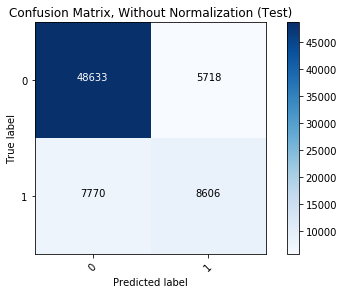

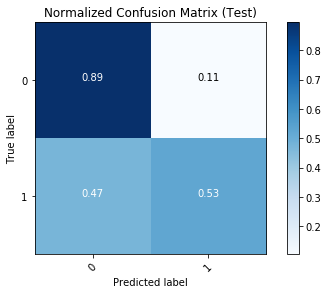

In [44]:
# Build the class names
class_names = ['0','1']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_test)
np.set_printoptions(precision = 2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix, Without Normalization (Test)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix (Test)')

### Build the Out of Time Confusion Matrix

Confusion matrix, without normalization
[[58290  6003]
 [ 5842  5617]]
Normalized confusion matrix
[[0.91 0.09]
 [0.51 0.49]]


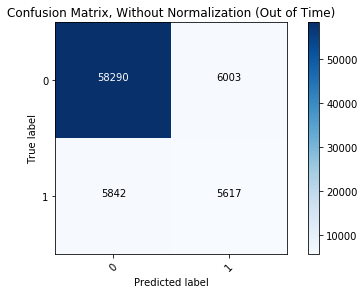

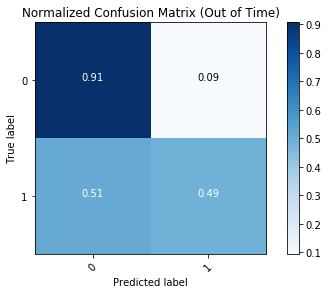

In [45]:
# Build the class names
class_names = ['0','1']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_OOT, y_OOT_pred)
np.set_printoptions(precision = 2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix, Without Normalization (Out of Time)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix (Out of Time)')

### Piece All the Data Back Together

In [48]:
df_y_test = pd.DataFrame(y_test, columns = ['target_actual'])
df_y_test_pred = pd.DataFrame(y_pred_test, columns = ['target_pred'])
df_X_test = pd.DataFrame(X_test, columns = ColumnList)
df_X_test_IDs = pd.DataFrame(X_test_IDs, columns = RemoveList)

df_test_XGB = pd.concat([df_X_test_IDs, df_X_test, df_y_test, df_y_test_pred], axis = 1)

df_y_OOT = pd.DataFrame(y_OOT, columns = ['target_actual'])
df_y_OOT_pred = pd.DataFrame(y_OOT_pred, columns = ['target_pred'])
df_X_OOT = pd.DataFrame(X_OOT, columns = ColumnList)
df_X_OOT_IDs = pd.DataFrame(X_OOT_IDs, columns = RemoveList)

df_OOT_XGB = pd.concat([df_X_OOT_IDs, df_X_OOT, df_y_OOT, df_y_OOT_pred], axis = 1)

display(HTML(df_test_XGB[0:10].to_html()))
display(HTML(df_OOT_XGB[0:10].to_html()))

,target,id,roa,int_rate,grade_A,grade_B,grade_C,grade_D,grade_E,OOT_Ind,funded_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,term__36_months,term__60_months,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_Other,home_ownership_RENT,verification_status_Not_Verified,verification_status_Source_Verified,verification_status_Verified,purpose_Other,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_Other,addr_state_TX,initial_list_status_f,initial_list_status_w,target_actual,target_pred
0,0,7675953,4,9,1,0,0,0,0,0,20000,3,108,252,0,0,32,0,224,487,31,59,0,34,257,4,13290,158,372,20,20,1,5,24,1,6,7,16,9,21,0,2,73,42,0,265,247,252,7070,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0,35793395,-69,13,0,0,1,0,0,0,12000,10,110,318,0,0,31,0,236,753,16,52,0,36,249,6,7138,128,193,20,20,1,5,10,1,5,7,7,4,9,0,3,100,60,0,296,233,294,6870,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
2,0,6695915,9,15,0,0,1,0,0,0,4000,0,121,66,0,2,18,0,227,875,18,54,0,25,233,2,2836,225,227,34,34,2,15,1,1,2,2,5,10,6,0,0,83,100,0,258,233,263,6870,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0
3,1,9229456,14,19,0,0,0,1,0,0,8000,2,113,135,0,1,26,0,177,348,9,41,0,34,219,7,1063,7,65,7,7,1,24,1,0,2,2,2,2,6,0,4,100,100,0,273,183,272,7020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1
4,0,6158826,4,6,1,0,0,0,0,0,12000,1,114,126,0,0,31,0,205,236,30,52,0,39,271,7,33583,166,191,18,15,1,4,10,0,5,6,8,18,11,0,4,100,0,0,300,265,292,7770,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
5,1,13267781,11,16,0,0,0,1,0,0,11525,10,110,219,0,1,38,0,226,488,37,53,0,26,259,8,11860,104,217,7,7,5,1,2,0,6,8,12,8,24,0,5,97,44,0,260,243,257,6720,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0
6,0,8971877,5,10,0,1,0,0,0,0,24000,8,120,15,1,1,27,0,172,300,49,56,0,40,219,4,9314,171,295,11,11,8,2,1,1,4,7,25,7,34,0,3,74,20,0,172,210,0,6970,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0
7,0,14407944,9,12,0,1,0,0,0,0,20000,4,111,253,0,1,43,1,162,190,36,54,0,38,228,7,1658,224,221,7,7,1,16,3,0,6,9,9,19,16,0,4,89,0,1,348,198,326,7220,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
8,0,6155924,7,15,0,0,1,0,0,0,6000,2,108,75,0,0,28,0,184,796,18,55,0,18,193,1,1244,0,273,24,24,0,37,0,0,7,8,16,0,18,0,1,88,62,0,184,190,0,6720,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
9,0,3368221,7,14,0,0,1,0,0,0,29175,10,110,86,0,1,27,0,193,688,27,51,0,34,208,4,228,135,169,15,15,3,15,3,0,2,

,target,id,roa,int_rate,grade_A,grade_B,grade_C,grade_D,grade_E,OOT_Ind,funded_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,term__36_months,term__60_months,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_Other,home_ownership_RENT,verification_status_Not_Verified,verification_status_Source_Verified,verification_status_Verified,purpose_Other,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_Other,addr_state_TX,initial_list_status_f,initial_list_status_w,target_actual,target_pred
0,1,44429213,10,15,0,0,0,1,0,1,10000,10,103,329,0,1,32,1,197,438,21,52,0,21,231,6,8514,128,193,22,22,0,6,6,0,4,4,10,7,14,0,1,100,25,1,217,223,230,7070,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0
1,0,44057008,7,9,0,1,0,0,0,1,18000,10,110,343,0,0,26,0,224,648,21,52,0,35,244,7,10148,152,199,30,30,3,11,0,0,2,2,6,11,7,0,1,100,33,0,293,244,289,7520,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0
2,0,44299188,6,8,0,1,0,0,0,1,24000,10,113,310,0,0,43,0,249,413,43,49,0,35,293,6,24776,139,147,31,31,2,12,12,0,11,16,20,9,30,0,2,97,5,0,286,272,280,7120,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3,0,44017917,2,5,1,0,0,0,0,1,24000,8,116,160,0,1,31,0,220,262,36,62,0,25,284,7,41292,82,500,15,15,0,3,4,0,4,5,17,3,33,0,5,100,14,0,258,278,246,7620,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
4,0,44259158,9,12,0,0,1,0,0,1,35000,10,113,324,0,0,35,0,239,499,33,52,0,35,272,10,15835,114,197,7,7,1,19,9,0,8,11,15,8,24,0,5,100,33,0,295,258,289,6920,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
5,0,44409194,7,14,0,0,1,0,0,1,6000,10,111,283,0,1,37,0,227,645,33,49,0,34,247,12,2863,119,148,22,18,4,6,6,0,4,10,7,11,18,0,6,90,40,0,281,200,269,6970,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
6,0,44409120,-59,13,0,0,1,0,0,1,18000,7,110,177,0,0,27,0,164,669,23,50,71,35,178,5,50,158,152,35,7,2,55,12,1,1,3,1,16,5,0,2,82,100,0,275,146,281,6870,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1
7,0,43801789,4,9,0,1,0,0,0,1,24000,1,111,163,0,1,28,0,228,687,19,50,0,24,245,3,712,163,156,26,26,1,137,2,0,1,5,2,6,12,0,2,89,100,0,242,211,235,7020,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
8,0,44087155,8,12,0,0,1,0,0,1,1500,5,107,162,0,1,22,1,179,470,12,47,0,24,209,4,3843,114,98,15,15,0,25,3,0,3,3,4,6,6,0,2,100,33,0,248,198,242,6670,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
9,0,41399898,8,13,0,0,1,0,0,1,8000,8,103,142,0,0,24,0,211,632,10,46,0,21,231,

In [49]:
# Save the DataFrames
df_test_XGB.to_pickle('df_test_XGB.pkl')
df_OOT_XGB.to_pickle('df_OOT_XGB.pkl')

In [50]:
end_time = time.time()

diff = end_time - begin_time

print("run time ...", "\n")
print(diff, "seconds")
print(diff / 60, "minutes")
print(diff / 3600, "hours")

run time ... 

42825.27137041092 seconds
713.754522840182 minutes
11.895908714003033 hours
